In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests

## 1) 載入資料集

In [64]:
url = 'https://github.com/1010code/iris-dnn-tensorflow/raw/master/data/Iris.csv'
s=requests.get(url).content
df_data=pd.read_csv(io.StringIO(s.decode('utf-8')))
df_data = df_data.drop(labels=['Id'],axis=1) # 移除Id
df_data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## 2) 手動編碼
處理名目資料 (Nominal variables) - 資料前處理
依據特徵資料的特性，可以選擇手動編碼或自動編碼。

### 使用編碼時機?
進行深度學習時，神經網路只能處理數值資料。因此我們需要將所有非數字型態的特徵進行轉換。

ex:

|  Iris-setosa |  Iris-versicolor | Iris-virginica  |
|:---:|:---:|:---:|
|  1 | 2  | 3  |

In [65]:
label_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

#將編碼後的label map存至df_data['Species']中。
df_data['Class'] = df_data['Species'].map(label_map)

In [66]:
df_data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Class
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,2
146,6.3,2.5,5.0,1.9,Iris-virginica,2
147,6.5,3.0,5.2,2.0,Iris-virginica,2
148,6.2,3.4,5.4,2.3,Iris-virginica,2


## 3) 檢查缺失值
使用 numpy 所提供的函式來檢查是否有 NA 缺失值，假設有缺失值使用dropna()來移除。使用的時機在於當只有少量的缺失值適用，若遇到有大量缺失值的情況，或是本身的資料量就很少的情況下建議可以透過機器學習的方法補值來預測缺失值。

```python
# 移除缺失值
train=train.dropna()
```

In [67]:
X = df_data.drop(labels=['Species','Class'],axis=1).values # 移除Species (因為字母不參與訓練)
# checked missing data
print("checked missing data(NAN mount):",len(np.where(np.isnan(X))[0]))

checked missing data(NAN mount): 0


## 4) 切割訓練集與測試集

In [68]:
from sklearn.model_selection import train_test_split
X=df_data.drop(labels=['Class','Species'],axis=1).values
y=df_data['Class'].values
X_train , X_test , y_train , y_test = train_test_split(X,y , test_size=.3 , random_state=42)

In [69]:
print('Training data shape:',X_train.shape)
print('Testing data shape:',X_test.shape)

Training data shape: (105, 4)
Testing data shape: (45, 4)


## 繪製決策邊界 Function

In [70]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx = None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                            np.arange(x2_min,x2_max,resolution))

    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)

    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0], y=X[y==cl,1],
            alpha=0.8, c=[cmap(idx)], marker=markers[idx],label=cl)
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:,1], c='',
            alpha=1.0, linewidth=1, marker='o',
            s=55, label='test set')


## PCA降維
將原先 iris 4個特徵降成2維，方便做視覺化。

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, iterated_power=1)
train_reduced = pca.fit_transform(X_train)
test_reduced = pca.transform(X_test)

## 分類決策樹
一個決策樹會根據訓練資料自動產生一棵樹。決策樹會根據資料產生很多樹狀的規則，最終訓練出來的規則會對新樣本進行預測。

Parameters:
- criterion: 亂度的評估標準，gini/entropy。預設為gini。
- max_depth: 樹的最大深度。
- splitter: 特徵劃分點選擇標準，best/random。預設為best。
- random_state: 亂數種子，確保每次訓練結果都一樣，splitter=random 才有用。
- min_samples_split: 至少有多少資料才能再分
- min_samples_leaf: 分完至少有多少資料才能分

Attributes:
- feature_importances_: 查詢模型特徵的重要程度。

Methods:
- fit: 放入X、y進行模型擬合。
- predict: 預測並回傳預測類別。
- score: 預測成功的比例。
- predict_proba: 預測每個類別的機率值。
- get_depth: 取得樹的深度。





train set accurancy:  1.0


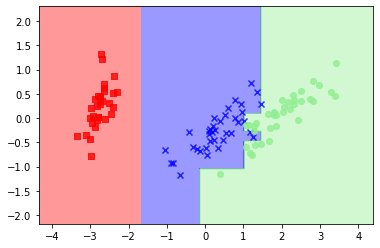

In [74]:
from sklearn.tree import DecisionTreeClassifier

# 建立Logistic模型
decisionTreeModel = DecisionTreeClassifier(criterion = 'entropy', max_depth=6, random_state=42)
# 使用訓練資料訓練模型
decisionTreeModel.fit(train_reduced, y_train)
# 使用訓練資料預測分類
predicted = decisionTreeModel.predict(train_reduced)

# 訓練集預測
plot_decision_regions(train_reduced, y_train, decisionTreeModel)
print('train set accurancy: ',decisionTreeModel.score(train_reduced, y_train))

test set accurancy:  0.9777777777777777


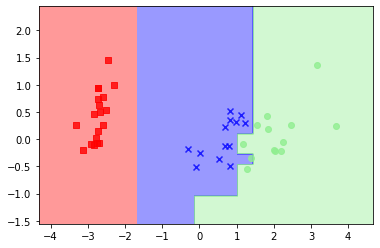

In [73]:
# 測試集預測
plot_decision_regions(test_reduced, y_test, decisionTreeModel)
print('test set accurancy: ',decisionTreeModel.score(test_reduced, y_test))

## 視覺化決策樹
Graphviz 是視覺化決策樹的套件，可參考Graphviz[官網](https://www2.graphviz.org/)的介紹。以下範例一樣用 iris 資料集，並採用四個特徵下去做訓練。

`pip install graphviz`


In [59]:
#create model
decisionTreeModel = DecisionTreeClassifier(criterion = 'gini', max_depth=3 ,random_state=42)
decisionTreeModel.fit(X_train, y_train)

print('train set accurancy: ',decisionTreeModel.score(X_train, y_train))
print('test set accurancy: ',decisionTreeModel.score(X_test, y_test))

train set accurancy:  0.9523809523809523
test set accurancy:  1.0


In [60]:
print('特徵重要程度: ',decisionTreeModel.feature_importances_)

特徵重要程度:  [0.         0.         0.92510833 0.07489167]


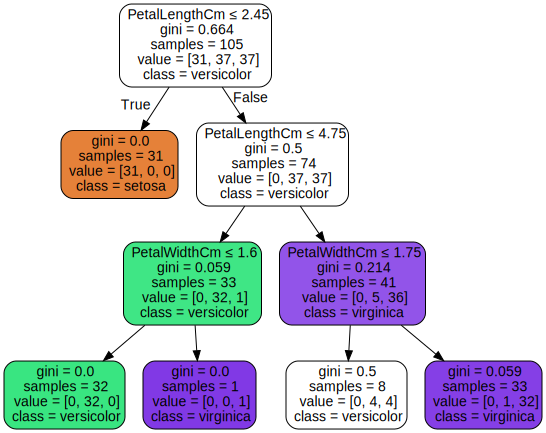

In [61]:
import graphviz
from sklearn.tree import export_graphviz
dot_data = export_graphviz(decisionTreeModel, out_file=None, 
                         feature_names=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'],
                         class_names=['setosa', 'versicolor', 'virginica'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph